In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (8,3)

In [58]:
df1 = pd.read_csv("Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [59]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

Drop society and availability because our model will be more generalized:

In [60]:
df2 = df1.drop(['society', 'availability'], axis = 'columns')
df2.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,1.0,51.00


Replace null values of each column:

In [61]:
df2.isnull().sum()

area_type       0
location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

In [62]:
df3 = df2.fillna({'balcony': 0})
df4 = df3.dropna()
df4.isnull().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

In [63]:
df4['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

Unify the formatting of the column showing number of bedrooms:

In [64]:
df4['bed'] = df4['size'].apply(lambda x: int(x.split(' ')[0]))
df4.head()

/var/folders/fg/lfqbtfkx5bgb_fzfthjb_xq40000gn/T/ipykernel_30736/1086156858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['bed'] = df4['size'].apply(lambda x: int(x.split(' ')[0]))


,area_type,location,size,total_sqft,bath,balcony,price,bed
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,2
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,4
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,3
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,3
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,1.0,51.00,2


In [65]:
df4['bed'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [66]:
df4['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

Return whether or not x is a float:

In [67]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [68]:
df4[~df4['total_sqft'].apply(is_float)].head()

,area_type,location,size,total_sqft,bath,balcony,price,bed
30,Super built-up Area,Yelahanka,4 BHK,2100 - 2850,4.0,0.0,186.000,4
122,Super built-up Area,Hebbal,4 BHK,3067 - 8156,4.0,0.0,477.000,4
137,Super built-up Area,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,0.0,54.005,2
165,Super built-up Area,Sarjapur,2 BHK,1145 - 1340,2.0,0.0,43.490,2
188,Super built-up Area,KR Puram,2 BHK,1015 - 1540,2.0,0.0,56.800,2


Change ranges of square foot data to the median:

In [69]:
def sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return(float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except: 
        return None

In [70]:
df4['total_sqft'] = df4['total_sqft'].apply(sqft_to_num)

/var/folders/fg/lfqbtfkx5bgb_fzfthjb_xq40000gn/T/ipykernel_30736/592210466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['total_sqft'] = df4['total_sqft'].apply(sqft_to_num)


In [71]:
df5 = df4.drop(['size'], axis = 1)
df5.head()

,area_type,location,total_sqft,bath,balcony,price,bed
0,Super built-up Area,Electronic City Phase II,1056.0,2.0,1.0,39.07,2
1,Plot Area,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4
2,Built-up Area,Uttarahalli,1440.0,2.0,3.0,62.00,3
3,Super built-up Area,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3
4,Super built-up Area,Kothanur,1200.0,2.0,1.0,51.00,2


In [72]:
len(df5.location.unique())

1304

Take leading and trailing spaces away from the locations:

In [73]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [74]:
len(location_stats[location_stats <= 10])

1052

In [75]:
len(df5.location.unique())

1293

Put locations mentioned 10 or less times in an 'other' row:

In [76]:
location_stats_10 = location_stats[location_stats<=10]
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_10 else x)
len(df4.location.unique())

1304

In [77]:
df6 = df5[~(df5.total_sqft/df5.bed<300)]
df6.shape

(12502, 7)

In [78]:
df6['price_per_sqft'] = (df6['price']/df6['total_sqft']) * 100000
df6.head()

/var/folders/fg/lfqbtfkx5bgb_fzfthjb_xq40000gn/T/ipykernel_30736/1490371872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['price_per_sqft'] = (df6['price']/df6['total_sqft']) * 100000


,area_type,location,total_sqft,bath,balcony,price,bed,price_per_sqft
0,Super built-up Area,Electronic City Phase II,1056.0,2.0,1.0,39.07,2,3699.810606
1,Plot Area,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4,4615.384615
2,Built-up Area,Uttarahalli,1440.0,2.0,3.0,62.00,3,4305.555556
3,Super built-up Area,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3,6245.890861
4,Super built-up Area,Kothanur,1200.0,2.0,1.0,51.00,2,4250.000000


In [79]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

If the price per sqft is outside of 1 standard deviation, remove it:

In [80]:
def remove_pps_outliers(df):
    out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        mean = np.mean(subdf.price_per_sqft)
        stdev = np.std(subdf.price_per_sqft)
        new = subdf[(subdf.price_per_sqft>(mean - stdev)) & (subdf.price_per_sqft<=(mean + stdev))]
        out = pd.concat([out, new], ignore_index = True)
    return out

In [81]:
df7 = remove_pps_outliers(df6)
df7.shape

(10241, 8)

In [82]:
df6['bed'].value_counts()

bed
2     5486
3     4739
4     1242
1      644
5      204
6       92
7       42
8       26
9       17
10       6
11       2
16       1
13       1
Name: count, dtype: int64

If price per square foot is lower than the mean price per square foot of houses with less bedrooms in the same location, remove it:

In [83]:
def remove_bed_outliers(df):
    to_remove = np.array([])
    for _, loc_df in df.groupby('location'): 
        bed_stats = {}
        for bed, bed_df in loc_df.groupby('bed'): #calculate mead, std, and count for houses with each # of beds for each location
            bed_stats[bed] = {
                'mean': np.mean(bed_df.price_per_sqft),
                'std': np.std(bed_df.price_per_sqft),
                'count': bed_df.shape[0]
            }
        for bed, bed_df in loc_df.groupby('bed'):
            prev = bed_stats.get(bed-1)
            if prev and prev['count']>5: #if there is a lower number of bedrooms and that lower number has at least 5 examples
                to_remove = np.append(to_remove, bed_df[bed_df.price_per_sqft<(prev['mean'])].index.values) #remove if value < mean of prev # of beds
    return df.drop(to_remove, axis = 'index')

In [84]:
df8 = remove_bed_outliers(df7)
df8.shape

(7329, 8)

Text(0, 0.5, 'Count')

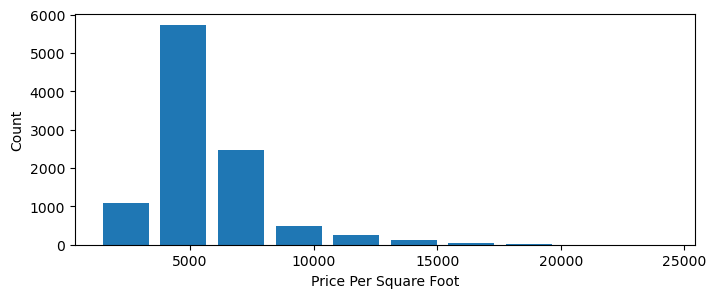

In [85]:
plt.hist(df7.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Foot")
plt.ylabel("Count")

If there are more than 2 more bathrooms than bedrooms in the house, remove it:

In [86]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [87]:
df8[df8.bath > df8.bed + 2]

,area_type,location,total_sqft,bath,balcony,price,bed,price_per_sqft
1626,Built-up Area,Chikkabanavar,2460.0,7.0,2.0,80.0,4,3252.032520
5238,Built-up Area,Nagasandra,7000.0,8.0,0.0,450.0,4,6428.571429
6711,Super built-up Area,Thanisandra,1806.0,6.0,2.0,116.0,3,6423.034330
8411,Super built-up Area,other,11338.0,9.0,1.0,1000.0,6,8819.897689


In [88]:
df9 = df8[df8.bath < df8.bed + 2]
df9.shape

(7251, 8)

In [89]:
df10 = df9.drop(['price_per_sqft'], axis = 'columns')
df10.head()

,area_type,location,total_sqft,bath,balcony,price,bed
0,Super built-up Area,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4
1,Super built-up Area,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3
2,Super built-up Area,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3
3,Built-up Area,1st Block Jayanagar,1200.0,2.0,0.0,130.0,3
4,Super built-up Area,1st Block Jayanagar,1235.0,2.0,2.0,148.0,2


Make dummy variables for the location column:

In [90]:
loc_dummies = pd.get_dummies(df10.location, dtype = int)
df11 = pd.concat([df10, loc_dummies.drop('other', axis = 'columns')], axis = 'columns')
df11.head()

,area_type,location,total_sqft,bath,balcony,price,bed,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,Super built-up Area,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Super built-up Area,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Super built-up Area,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Built-up Area,1st Block Jayanagar,1200.0,2.0,0.0,130.0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Super built-up Area,1st Block Jayanagar,1235.0,2.0,2.0,148.0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
df12 = df11.drop('location', axis='columns')
df12.head()

,area_type,total_sqft,bath,balcony,price,bed,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,Super built-up Area,2850.0,4.0,1.0,428.0,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Super built-up Area,1630.0,3.0,2.0,194.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Super built-up Area,1875.0,2.0,3.0,235.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Built-up Area,1200.0,2.0,0.0,130.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Super built-up Area,1235.0,2.0,2.0,148.0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Make dummy variables for the area_type column:

In [92]:
df12.area_type = df12.area_type.apply(lambda x: x.strip())
df12['area_type'].value_counts()

area_type
Super built-up  Area    5291
Built-up  Area          1315
Plot  Area               603
Carpet  Area              42
Name: count, dtype: int64

In [93]:
area_dummies = pd.get_dummies(df12.area_type, dtype = int)
area_dummies

,Built-up Area,Carpet Area,Plot Area,Super built-up Area
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,1,0,0,0
4,0,0,0,1
...,...,...,...,...
10232,0,1,0,0
10233,0,0,0,1
10236,0,0,0,1
10237,0,0,1,0


In [94]:
df13 = pd.concat([df12, area_dummies.drop('Carpet  Area', axis = 'columns')], axis = 'columns')
df13.head()

,area_type,total_sqft,bath,balcony,price,bed,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,Built-up Area,Plot Area,Super built-up Area
0,Super built-up Area,2850.0,4.0,1.0,428.0,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Super built-up Area,1630.0,3.0,2.0,194.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Super built-up Area,1875.0,2.0,3.0,235.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Built-up Area,1200.0,2.0,0.0,130.0,3,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Super built-up Area,1235.0,2.0,2.0,148.0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [95]:
df14 = df13.drop('area_type', axis='columns')
df14.head()

,total_sqft,bath,balcony,price,bed,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,Built-up Area,Plot Area,Super built-up Area
0,2850.0,4.0,1.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1630.0,3.0,2.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1875.0,2.0,3.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1200.0,2.0,0.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1235.0,2.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [96]:
df14.shape

(7251, 249)

Split into input-output and train-test:

In [106]:
x = df14.drop('price', axis = 'columns')
x.head()

,total_sqft,bath,balcony,bed,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,Built-up Area,Plot Area,Super built-up Area
0,2850.0,4.0,1.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1630.0,3.0,2.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1875.0,2.0,3.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1200.0,2.0,0.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1235.0,2.0,2.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [98]:
y = df14.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [151]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = .2, random_state = 10)

from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(x_train, y_train)
lr_clf.score(x_test, y_test)

0.8474419119207869

Use K-Fold Cross Validation and Grid Search CV to decide best model:

In [152]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits = 5, test_size = .2, random_state = 0)
cross_val_score(LinearRegression(), x, y, cv = cv)

array([0.82655455, 0.77232218, 0.85206325, 0.81000088, 0.83480524])

In [101]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

algos = {
    'linear_regression' : {
        'model' : LinearRegression(),
        'params' : {
            'fit_intercept' : [True, False]
        }
    }, 
    'lasso' : {
        'model' : Lasso(),
        'params' : {
            'alpha' : [1,2],
            'selection': ['random', 'cyclic']
        }
    }, 
    'decision_tree' : {
        'model' : DecisionTreeRegressor(),
        'params' : {
            'criterion' : ['friedman_mse', 'absolute_error', 'poisson'],
            'splitter' : ['best', 'random']
        }
    }
}
scores = []
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
for algo_name, config in algos.items():
    gs = GridSearchCV(config['model'], config['params'], cv = cv, return_train_score = False)
    gs.fit(x,y)
    scores.append({
        'model' : algo_name,
        'best_score' : gs.best_score_,
        'best_params' : gs.best_params_
    })
pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])


,model,best_score,best_params
0,linear_regression,0.819427,{'fit_intercept': False}
1,lasso,0.689978,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.703242,"{'criterion': 'poisson', 'splitter': 'best'}"


Models tested below time out:

In [102]:
from sklearn import preprocessing
from sklearn import utils

def best_clas_model(x, y):
    lab = preprocessing.LabelEncoder()
    x.total_sqft = lab.fit_transform(x.total_sqft)
    x.bath = lab.fit_transform(x.bath)
    x.balcony = lab.fit_transform(x.balcony)
    y_transformed = lab.fit_transform(y)

    clas_algos = {
        'svm': {
            'model': svm.SVC(gamma = 'auto'),
            'params': {
                'C': [1, 5, 10, 20],
                'kernel': ['rbf', 'linear']
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [1, 5, 10, 20]
            }
        },
        'logistic_regression': {
            'model': LogisticRegression(solver='liblinear', multi_class='auto'),
            'params': {
                'C': [1, 5, 10, 20]
            }
        }
    }
    clas_scores = []
    clas_cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    for algo_name, config in clas_algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv = clas_cv, return_train_score = False)
        gs.fit(x,y_transformed)
        clas_scores.append({
            'model' : algo_name,
            'best_score' : gs.best_score_,
            'best_params' : gs.best_params_
        })
    pd.DataFrame(clas_scores, columns = ['model', 'best_score', 'best_params'])

Use the best model to predict prices:

In [165]:
def predict_prices(location, area_type, sqft, bath, balcony, bed):
    loc_index = np.where(x.columns == location)[0][0]
    area_index = np.where(x.columns == area_type)[0][0]
    
    arr = np.zeros(len(x.columns))
    arr[0] = sqft
    arr[1] = bath
    arr[2] = balcony
    arr[3] = bed
    
    if (loc_index >= 0) and (area_index >= 0):
        arr[loc_index] = 1
        
    return lr_clf.predict([arr])[0]

In [166]:
predict_prices('1st Phase JP Nagar', 'Super built-up  Area', 1000, 3, 1, 2)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


98.08979564804466

In [167]:
predict_prices('Indira Nagar', 'Built-up  Area', 1000, 3, 2, 3)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


192.82645089172868

Save the model:

In [168]:
import pickle
with open('Bengaluru_house_prices_model.pickle', 'wb') as f:
    pickle.dump(lr_clf, f)

In [169]:
x.columns

Index(['total_sqft', 'bath', 'balcony', 'bed', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       ...
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur', 'Built-up  Area',
       'Plot  Area', 'Super built-up  Area'],
      dtype='object', length=248)

In [170]:
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))